/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


       0/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Generator Loss: 2.0778, Discriminator Loss: 0.3384
Epoch 2, Generator Loss: 1.4027, Discriminator Loss: 0.8361
Epoch 3, Generator Loss: 1.1601, Discriminator Loss: 0.8905
Epoch 4, Generator Loss: 1.5609, Discriminator Loss: 0.7608
Epoch 5, Generator Loss: 1.1407, Discriminator Loss: 1.4245
Epoch 6, Generator Loss: 1.1910, Discriminator Loss: 1.0416
Epoch 7, Generator Loss: 1.0848, Discriminator Loss: 1.1619
Epoch 8, Generator Loss: 0.8694, Discriminator Loss: 1.3907
Epoch 9, Generator Loss: 0.9331, Discriminator Loss: 1.3851
Epoch 10, Generator Loss: 0.9354, Discriminator Loss: 1.1762


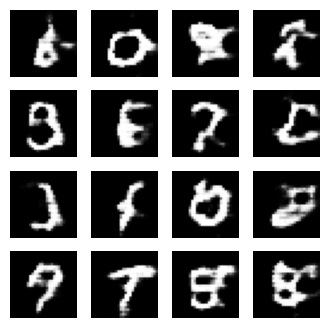

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


# Load and preprocess MNIST dataset
def load_data():
  (x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
  x_train = (x_train.astype("float32") - 127.5) / 127.5  # Normalize to -1 to 1
  x_train = np.expand_dims(x_train, axis=-1) # Add channel dimension
  return tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128).prefetch(tf.data.AUTOTUNE)

def build_generator():
  model = tf.keras.Sequential([
      layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
      layers.BatchNormalization(), # Normalize to -1 to 1
      layers.ReLU(),
      layers.Reshape((7, 7, 256)),
      layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])
  return model

def build_discriminator():
  model = tf.keras.Sequential([
      layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
      layers.LeakyReLU(alpha=0.2),
      layers.Dropout(0.3),
      layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
      layers.LeakyReLU(alpha=0.2),
      layers.Dropout(0.3),
      layers.Flatten(),
      layers.Dense(1, activation = 'sigmoid')
  ])
  return model


def get_optimizer():
  return tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.Adam(1e-4)

generator = build_generator()
discriminator = build_discriminator()
g_opt, d_opt = get_optimizer()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# discriminator wants real imgs as 1, fake imgs as 0
# Generator wants fake imgs to be classified as real (1)

@tf.function # Compilers to a Tensorflow graph for speed
def train_step(images):
  noise = tf.random.normal([128, 100]) # creates a batch of 128 random noise vectors, each of size 100-dimensioinal

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True) # generator takes the random noise as input and produces fake imgs resembling real MNIST digits
    real_output = discriminator(images, training=True) # discriminator predicts whether real MNIST imgs are real (should be close to 1)
    fake_output = discriminator(generated_images, training=True) # discriminator predicts whether fake MNIST imgs are real (should be close to 0)

    gen_loss = loss_fn(tf.ones_like(fake_output), fake_output) # tf.ones_like(fake_output) creates a tensor fo ones, representing "real" labels
                                                               # loss_fn (Binary Crossentropy loss) measures how close fake_output is to 1
                                                               # lower generator loss means the generator is successfully fooling the discriminator
                                                               # higher generator loss mens the generator is performing poorly

    disc_loss = (loss_fn(tf.ones_like(real_output), real_output) + # how well the discriminator classifies real imgs as real (close to 1)
                 loss_fn(tf.zeros_like(fake_output), fake_output)) # # how well the discriminator classifies fake imgs as fake (close to 0) - same as gen_loss


  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # compute gradients for generator parameters
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # compute gradients for discriminator parameters

  g_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # update generator's weights
  d_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # update discriminator's weights

  return gen_loss, disc_loss

def train(dataset, epochs=10):
  for epoch in range(epochs):
    for batch in dataset:
      gen_loss, disc_loss = train_step(batch)

    print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}")

def generate_and_show():
  noise = tf.random.normal([16, 100])
  images = generator(noise, training=False)
  images = (images + 1) / 2 # Rescale to [0,1]
  fig, axs = plt.subplots(4, 4, figsize=(4, 4))
  for i, ax in enumerate(axs.flat):
    ax.imshow(images[i, :, :, 0], cmap='gray')
    ax.axis('off')
  plt.show()

# Load data and train
mnist_data = load_data()
train(mnist_data)
generate_and_show()

The **@tf.function** decorator compiles the function into a Tensorflow computationla graph.This makes execution significantly faster because ⁉

  1.Tensorflow optimizers the operations for GPUs.

  2.It avoids python overhead by compiling it into low level operations.

  3.It allows lle execution where possible

This is benefical cause training DL models is computationally intensive. adn performace imporvements matter.

  (i) Early Training: The generator is weak, so fake_output is low gen_loss is high (cause G is failing) The discriminator matter.

  (ii) Mid Training: The generator imporves, so fake_output increases. gen_loss starts decreasing The discriminator matter gets confused.so disc_loss increases.

  (iii)Late Training: THe generator is very strong. and fake_output = real_output The discrimintor struggles. so both terms in dis_loss balance out.Both gen_loss and disc_loss settle near equillibrium.


**tf.GradientTape()** is a Tensorflow tool used for automatic differentation, it helps compute gradients of operations with respect to varibles.

How it Works:-

  1.Records operations: tf.GradientTape() keeps track of math opern performed on tensors inside its with block

  2.Compute gradients: After executing operns. we can call gradient(loss, varibles) to compute gradients of the loss with respect to the model parameters.

  3.Applies gradients:The computed gradients are then used by an optimizer(eg. Adam) to update the model's weights


  .shuffle(60000)

  Randomly shuffles the dataset with a buffer size of 60000. Ensures that each batch gets a diverse mix of data, which helps with generalization.

  .batch(128)

  Groups the data into batches of 128 samples each for effcient processing. Instead of processing one sample at a time, the model processes 128 samples together.

  .perfetch(tf.data.AUTOTUNE)

  Optimizes data loading by prefetching batches in the background while the model is training, tf.data.AUTOTUNE allows Tensorflow to automatically decide the optimal nor of batches to prefetch based on system resources.